## Route Profitability Analysis

### Objective:
The goal of this project is to identify the most and least profitable airline routes in the U.S. using historical flight fare and route data. By comparing estimated operating costs against passenger revenues, we aim to determine which city pairs generate the highest returns—and which consistently operate at a loss.

### Key Features:
- **Revenue Modeling**: Based on average fare and passenger volume per route.
- **Cost Estimation**: Estimated operating cost using distance, block time, and quarterly cost per block-minute (derived from A4A trend reports).
- **Profitability Metrics**: Calculate per-route profit and profit margins.
- **Interactive Visualizations**: Top and bottom 10 routes plotted geospatially for selected quarters.
- **Custom API Functions**: Query route-level profitability on demand.

### Dataset:
The base dataset is sourced from [Kaggle: US Airline Flight Routes and Fares](https://www.kaggle.com/datasets/amitzala/us-airline-flight-routes-and-fares). It includes over 240,000 records of domestic routes with quarterly details on fares, distance, passengers, and airport pairs.

### Operating Cost Source:
Quarterly cost per block-minute is interpolated based on industry data from Airlines for America (A4A). Reported costs include fuel, crew, and maintenance expenses for U.S. passenger airlines. These estimates span from 1993 to 2024.
Reference: [Airlines for America (A4A) Economic Reports](https://www.airlines.org/dataset/per-minute-cost-of-operating-aircraft-paci/)

### Tools & Techniques:
- Python (pandas, numpy, plotly)
- REST-style helper functions
- Interpolated quarterly operating cost modeling (based on A4A block-minute estimates)

This analysis enables airline planners and data analysts to explore which routes could benefit from optimization through fleet assignment, pricing strategy, or frequency adjustment.

Adapted REST API with dataset integration for notebook environments:

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np
import pandas as pd

!pip install plotly
import plotly.graph_objects as go

In [2]:
# Authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Dataset slug
dataset = "amitzala/us-airline-flight-routes-and-fares"

# Download to current directory
api.dataset_download_files(dataset, path="data", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/amitzala/us-airline-flight-routes-and-fares


In [3]:
df = pd.read_csv("data/US Airline Flight Routes and Fares.csv")
df.head()

C:\Users\slind\AppData\Local\Temp\ipykernel_9956\940454710.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/US Airline Flight Routes and Fares.csv")


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,...,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,...,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,...,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,...,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,...,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245955 entries, 0 to 245954
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tbl             245955 non-null  object 
 1   Year            245955 non-null  int64  
 2   quarter         245955 non-null  int64  
 3   citymarketid_1  245955 non-null  int64  
 4   citymarketid_2  245955 non-null  int64  
 5   city1           245955 non-null  object 
 6   city2           245955 non-null  object 
 7   airportid_1     245955 non-null  int64  
 8   airportid_2     245955 non-null  int64  
 9   airport_1       245955 non-null  object 
 10  airport_2       245955 non-null  object 
 11  nsmiles         245955 non-null  int64  
 12  passengers      245955 non-null  int64  
 13  fare            245955 non-null  float64
 14  carrier_lg      244415 non-null  object 
 15  large_ms        244415 non-null  float64
 16  fare_lg         244415 non-null  float64
 17  carrier_lo

## Dataset Description:
The dataset contains quarterly records of U.S. domestic airline routes, including:
- Origin and destination cities and airports
- Fare information and number of passengers
- Distance in nautical miles
- Carrier types and market share estimates
- Time period (year and quarter)

Each row represents a unique route per quarter, enabling trend analysis and profitability modeling.

## Route Profitability Modeling

This section simulates quarterly operating costs from 1993 to 2024 using a linear interpolation of block-minute costs derived from A4A (Airlines for America) economic trend data. These costs include fuel, crew, and maintenance expenses and are assumed to rise gradually from $50.00 to $102.00 per block-minute over the 31-year span.

Each route in the dataset is enriched with distance (converted to km), estimated block minutes (assuming average aircraft speed of 850 km/h), and interpolated cost per block-minute based on the flight's corresponding year and quarter.

Using this, we compute:
- Estimated revenue (average fare × passengers)
- Estimated operating cost (block_minutes × cost per block-minute)
- Profit and profit margin per route
These values allow us to analyze airline route profitability at a granular level.

Additionally, we parse geographic coordinates for route visualization and define utility functions to plot and query top/bottom routes per quarter.

In [5]:
# Generate historical block-minute cost estimates per quarter from 1993 to 2024
quarters = pd.date_range(start='1993-01-01', end='2024-12-31', freq='QS')
n_quarters = len(quarters)
block_min_costs = np.linspace(50.00, 102.00, n_quarters)
cost_table = pd.DataFrame({
    'year': quarters.year,
    'quarter': quarters.quarter,
    'block_min_cost': np.round(block_min_costs, 2)
})

# Prepare dataset
df.columns = df.columns.str.replace(" ", "_").str.lower()
df['distance'] = df['nsmiles'] * 1.852  # Convert nautical miles to km

# Merge cost by year and quarter
df = df.merge(cost_table, how='left', left_on=['year', 'quarter'], right_on=['year', 'quarter'])

# Estimate block minutes and operating costs using interpolated cost
AVG_SPEED_KMH = 850
df['block_minutes'] = (df['distance'] / AVG_SPEED_KMH) * 60

# Use available fare and passengers
df['average_fare'] = df['fare']
df['revenue'] = df['passengers'] * df['average_fare']
df['operating_cost'] = df['block_minutes'] * df['block_min_cost']
df['profit'] = df['revenue'] - df['operating_cost']
df['margin'] = df['profit'] / df['revenue']

# Parse coordinates from geocoded fields
def parse_coords(coord_str):
    try:
        return tuple(map(float, coord_str.strip('()').split(',')))
    except:
        return (None, None)

df[['lat1', 'lon1']] = df['geocoded_city1'].apply(parse_coords).apply(pd.Series)
df[['lat2', 'lon2']] = df['geocoded_city2'].apply(parse_coords).apply(pd.Series)

# Visualize top/bottom profitable routes for a specific quarter in a year
def plot_top_and_bottom_routes_by_quarter(year, quarter):
    filtered_df = df[(df['year'] == year) & (df['quarter'] == quarter) & df[['lat1', 'lon1', 'lat2', 'lon2']].notnull().all(axis=1)]
    agg_df = filtered_df.groupby(['airportid_1', 'airportid_2', 'lat1', 'lon1', 'lat2', 'lon2', 'city1', 'city2']).agg({
        'profit': 'sum'
    }).reset_index()

    # Drop duplicates based on city-pairs to avoid multiple entries with same route
    agg_df = agg_df.sort_values('profit', ascending=False).drop_duplicates(subset=['city1', 'city2'])
    top_routes = agg_df.head(10).copy()

    agg_df = agg_df.sort_values('profit', ascending=True).drop_duplicates(subset=['city1', 'city2'])
    bottom_routes = agg_df.head(10).copy()

    fig = go.Figure()

    for idx, row in top_routes.iterrows():
        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            lon=[row['lon1'], row['lon2']],
            lat=[row['lat1'], row['lat2']],
            mode='lines',
            line=dict(width=2, color='green'),
            opacity=0.7,
            name=f"{row['city1']} → {row['city2']} | Profit: ${row['profit']:,.0f}"
        ))

    for idx, row in bottom_routes.iterrows():
        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            lon=[row['lon1'], row['lon2']],
            lat=[row['lat1'], row['lat2']],
            mode='lines',
            line=dict(width=2, color='red'),
            opacity=0.7,
            name=f"{row['city1']} → {row['city2']} | Loss: ${abs(row['profit']):,.0f}"
        ))

    fig.update_layout(
        title=f'Top & Bottom Airline Route Profitability (USA) - {year} Q{quarter}',
        geo=dict(scope='usa'),
        showlegend=True
    )
    fig.show()


def get_route_profit_notebook(origin_id, dest_id, year):
    filtered = df[(df['airportid_1'] == origin_id) & (df['airportid_2'] == dest_id) & (df['year'] == year)]
    if filtered.empty:
        return {'error': 'No data found for given route and year'}

    row = filtered.iloc[0]
    return {
        'origin_id': row['airportid_1'],
        'destination_id': row['airportid_2'],
        'year': row['year'],
        'quarter': row['quarter'],
        'distance_km': round(row['distance'], 2),
        'block_minutes': round(row['block_minutes'], 2),
        'block_min_cost_usd': round(row['block_min_cost'], 2),
        'average_fare': round(row['average_fare'], 2),
        'passengers': int(row['passengers']),
        'revenue': round(row['revenue'], 2),
        'operating_cost': round(row['operating_cost'], 2),
        'profit': round(row['profit'], 2),
        'margin': round(row['margin'], 4)
    }


def get_top_profitable_notebook(year=None, top_n=10):
    if year is None:
        year = df['year'].max()
    filtered = df[df['year'] == year].nlargest(top_n, 'profit')
    return filtered[['airportid_1', 'airportid_2', 'profit']].to_dict(orient='records')

This visualization displays the **most and least profitable U.S. domestic airline routes** for **Q3 2019**, based on route-level revenue and estimated operating costs.

Operating cost is calculated using **interpolated quarterly block-minute costs** derived from historical **Airlines for America (A4A)** industry data (1993–2024).

 **Green lines** indicate routes with the highest profits.
 **Red lines** represent the most loss-making routes.

Route profitability is computed from average fare, passenger volume, distance, and estimated block time, enabling a realistic view of airline performance by city pair.

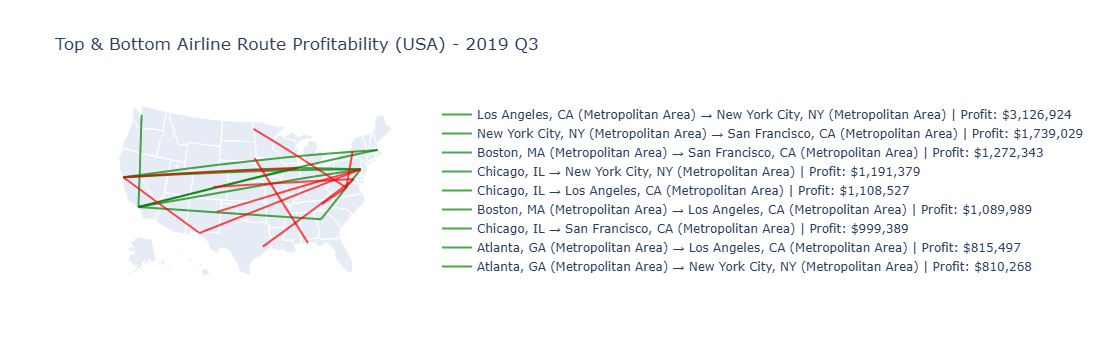

In [6]:
plot_top_and_bottom_routes_by_quarter(year=2019, quarter=3)

### Conclusion

This analysis reveals significant disparities in profitability across U.S. domestic airline routes. Routes connecting major economic and population hubs (e.g., **Los Angeles ↔ New York City**) consistently demonstrate strong profitability, largely due to high demand, premium fares, and efficient aircraft utilization. In contrast, some high-traffic routes still operate at a loss, often due to elevated operating costs, pricing competition, or low yield per passenger.

The use of **quarterly interpolated block-minute cost estimates**, modeled from **Airlines for America (A4A)** data, allows for a dynamic and realistic simulation of airline operational expenses over time.

### Recommendations

1. **Optimize Low-Yield Routes**
   Airlines should reevaluate low-profit or loss-making routes. Potential actions include reducing flight frequency, right-sizing aircraft, or exploring seasonal operations.

2. **Capitalize on High-Margin Routes**
   Highly profitable city-pairs offer opportunities to increase frequency, introduce premium cabins, or apply dynamic pricing models to further boost revenue.

3. **Incorporate Time Trends**
   Since operational costs vary significantly over time, future models should integrate **economic indicators** (e.g., fuel prices, inflation) to improve forecasting accuracy.

4. **Evaluate Competition Impact**
   Competitive pressure likely contributes to losses on major routes. Combining this dataset with market share or carrier-specific fare data could uncover deeper pricing insights.

5. **Use for Strategic Planning**
   This model can serve airline network planners as a decision-support tool to continuously monitor performance and adjust strategies by quarter or market.